# Exploring BPZ Test Data

_Alex Malz & Phil Marshall_

We have two datasets of photometric redshift 1D posterior PDFs in "gridded" format to test our `qp` approximations on: 

* ~30,000 from Melissa Graham (UW, LSST) from  LSST+Euclid/WFIRST-like mock data
* ~100,000 from Sam Schmidt (UC Davis, LSST) from LSST-like mock data

In this notebook we visualize these distributions and develop machinery to evaluate our approximations on the whole set in "survey mode." 

## Set-up, Ingest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
    
import hickle
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
import random
import cProfile
import pstats
import StringIO
import timeit
import psutil

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import qp

The data files don't appear to come with redshifts at which the PDFs are evaluated, but we are told they're evenly spaced between given endpoints.

In [3]:
# choose one of these:
dataname = 'mg'
# dataname = 'ss'

if dataname == 'mg':
    # Melissa Graham's data
    datafilename = 'bpz_euclid_test_10_2.probs'
    z_low = 0.01
    z_high = 3.51
elif dataname == 'ss':
    # Sam Schmidt's data
    datafilename = 'test_magscat_trainingfile_probs.out'
    z_low = 0.005
    z_high = 2.11

In [4]:
z = np.arange(z_low, z_high, 0.01, dtype='float')
z_range = z_high - z_low
delta_z = z_range / len(z)

## Warning: reading in the data is slow for Sam Schmidt's dataset!
with open(datafilename, 'rb') as data_file:
    lines = (line.split(None) for line in data_file)
    lines.next()
    pdfs = np.array([[float(line[k]) for k in range(1,len(line))] for line in lines])

## Visualizing the BPZ $p(z)$'s

Let's plot a few interesting PDFs from the dataset.

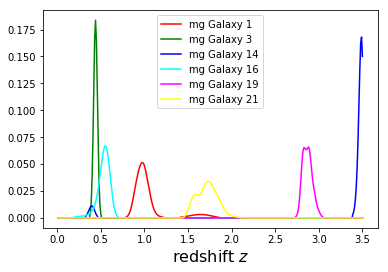

In [5]:
colors = ['red','green','blue','cyan','magenta','yellow']
n_plot = len(colors)

if dataname == 'mg':
    indices = [1, 3, 14, 16, 19, 21]
elif dataname == 'ss':
    n_gals_tot = len(pdfs)
    full_gal_range = range(n_gals_tot)
    indices = np.random.choice(full_gal_range, n_plot)

for i in range(n_plot):
    plt.plot(z, pdfs[indices[i]], color=colors[i], label=dataname+' Galaxy '+str(indices[i]))
plt.xlabel('redshift $z$', fontsize=16)
plt.legend();

Now, let's turn one of them into a `qp.PDF` object initialized with a gridded parametrization.  

Note: The PDFs in the data file weren't properly normalized.  In order to be PDFs, we want $\int\ p(z)\ dz=1$, but the data file entries satisfy $\sum_{z}\ p(z)=1$, which is not the same.  `qp` approximates the desired integral as $\int\ p(z)\ dz\ \approx\ \Delta z\ \sum_{i}^{N}\ p(z_{i})$ where $\Delta z=\frac{z_{max}-z_{min}}{N}$ is the distance between each neighbor pair $i$ of $N$ redshifts at which the PDF is evaluated.

Plotted gridded.


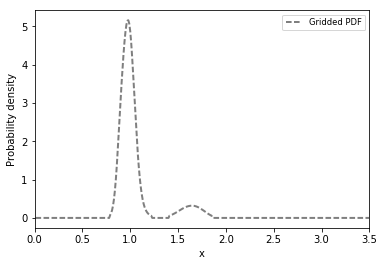

In [6]:
if dataname == 'mg':
    chosen = 1
elif dataname == 'ss':
    chosen = 108019

G = qp.PDF(gridded=(z, pdfs[chosen]))
G.plot()

## Approximating the BPZ $p(z)'s$


Quantile and histogram representations cannot be computed directly from gridded PDFs - we need to make a GMM first, and use this to instantiate a `qp.PDF` object using a `qp.composite` object based on that GMM as `qp.PDF.truth`.  We can fit a GMM directly to the gridded PDF, or we can sample it and fit a GMM to the samples.

(array([  9.50296130e-02,   9.13478664e-01,   6.00090910e-14]), array([ 1.63821369,  0.97362529,  0.01000003]), array([ 0.11477798,  0.07009695,  0.01011561]))
0.0950296130204$\cdot\mathcal{N}($1.63821369069,0.114777982467)\n0.913478664431$\cdot\mathcal{N}($0.973625286165,0.0700969523659)\n6.00090910438e-14$\cdot\mathcal{N}($0.010000025646,0.0101156124227)\n
Plotted mixture model.
Plotted gridded.


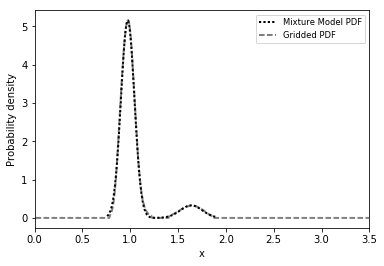

In [7]:
if dataname == 'mg':
    nc_needed = 3
elif dataname == 'ss':
    nc_needed = 5

G.mix_mod_fit(n_components=nc_needed)
G.plot()

We can also fit the GMM to samples, producing a very similar `qp.composite` object.

(array([  9.50296130e-02,   9.13478664e-01,   6.00090910e-14]), array([ 1.63821369,  0.97362529,  0.01000003]), array([ 0.11477798,  0.07009695,  0.01011561]))
0.0950296130204$\cdot\mathcal{N}($1.63821369069,0.114777982467)\n0.913478664431$\cdot\mathcal{N}($0.973625286165,0.0700969523659)\n6.00090910438e-14$\cdot\mathcal{N}($0.010000025646,0.0101156124227)\n
Plotted mixture model.
Plotted gridded.
Interpolating the `samples` parametrization
Creating a `linear` interpolator for the samples parametrization.
Plotted samples


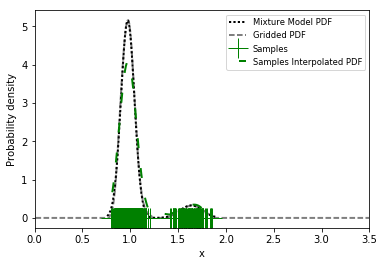

In [8]:
G.sample(1000, vb=False)
M_dist = G.mix_mod_fit(n_components=nc_needed, vb=True)
G.plot()

The `qp.composite` object can be used as the `qp.PDF.truth` to initialize a new `qp.PDF` object that doesn't have any information about the gridded or sample approximations.  Now we can approximate it any way we like!

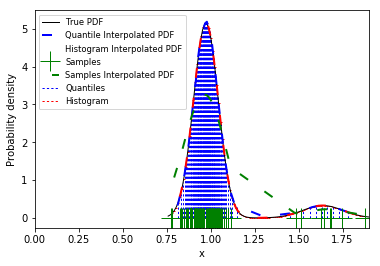

In [9]:
M = qp.PDF(truth=M_dist)
M.sample(N=100,vb=False)
M.quantize(N=100, vb=False)
M.histogramize(N=100, vb=False)
M.plot(vb=False)

## Quantifying the Accuracy of the Approximation

Let's start by computing the RMSE and KLD between each approximation and the truth, in a sample of systems - and then graduate to looking at the estimated $n(z)$. We'll need a function to do all the analysis on a single object, and then accumulate the outputs to analyze them.

In [10]:
# this is a test of the experimental qp.Ensemble object!

def analyze(pdfs, N_comps, z, N_floats):
    z_low, z_high = min(z), max(z)
    N_pdfs = len(pdfs)
    out_E = {}
    E = qp.Ensemble(N_pdfs, gridded=(z, pdfs))
    E.sample(100)
    GMMs = E.mix_mod_fit(N=N_comps)
    Ef = qp.Ensemble(N_pdfs, truth=GMMs)
    out_E['truth'] = Ef
    #Et = qp.Ensemble(N_pdfs, gridded=Ef.evaluate(z))
    #t_stack = Et.stack(z, using='gridded')
    #out_E['gridded'] = Et
    Eq = qp.Ensemble(N_pdfs, quantiles=Ef.quantize(N=N_floats))
    #q_stack = Eq.stack(z, using='quantiles')
    out_E['quantiles'] = Eq
    Eh = qp.Ensemble(N_pdfs, histogram=Ef.histogramize(N=N_floats, binrange=(z_low, z_high)))
    #h_stack = Eh.stack(z, using='histogram')
    out_E['histogram'] = Eh
    Es = qp.Ensemble(N_pdfs, samples=Ef.sample(N=N_floats))
    #s_stack = Es.stack(z, using='samples')
    out_E['samples'] = Es
    return(out_E)#, KLDs, RMSEs)

In [11]:
# this is a test of the experimental qp.Ensemble object!

n_gals_tot = len(pdfs)
full_gal_range = range(n_gals_tot)
subset = np.random.choice(full_gal_range, 6)
pdfs_to_use = pdfs[subset]
results = analyze(pdfs_to_use, 2, z, 10)

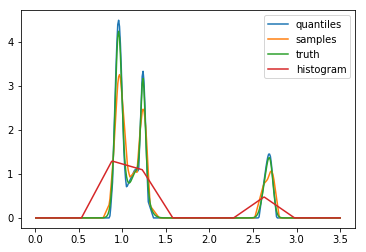

In [12]:
stack_ests = {}
for est in results.keys():
    to_plot = results[est].stack(z, using=est)
    stack_ests[est] = to_plot
    plt.plot(to_plot[0], to_plot[1], label=est)
plt.legend()

In [13]:
P = qp.PDF(gridded=stack_ests['truth'])

KLDs, RMSEs = {}, {}
for est in stack_ests.keys():
    Q = qp.PDF(gridded=stack_ests[est])
    KLDs[est] = qp.utils.calculate_kl_divergence(P, Q, vb=False)
    RMSEs[est] = qp.utils.calculate_rmse(P, Q, vb=False)

In [14]:
# this ends the test of the experimental qp.Ensemble object
# you may now return to your regularly scheduled programming

In [15]:
# def analyze_one(index, N_comps, z, N_floats, logfilename='logfile.txt', vb=False):
#     """
#     Model the input BPZ P(z) as a GMM, approximate that GMM in 
#     various ways, and assess the quality of each approximation.
    
#     Parameters
#     ----------
#     index : int
#         ID of galaxy
#     N_comps : int
#         Number of components used in GMM
#     N_floats : int
#         Number of floats used to parametrize the P(z)
#     z : float, ndarr
#         Redshift array for input gridded "truth". Used for 
#         evaluating n(z) too
#     logfilename: string
#         where to put logging information
#     vb : boolean
#         Verbose output?

#     Returns
#     -------
#     result : dict
#         Dictionary containing metric values, n(z) on standard 
#         grid, samples, "true" GMM gridded p(z).
        
#     Notes
#     -----
#     In some cases the GMM does not fit well, leading to bad KLD and 
#     RMSE values when it is compared to the truth.
    
#     """
# #     # Make z array if we don't already have it:
# #     if z is None:
# #         z = np.arange(0.01, 3.51, 0.01, dtype='float')
#     dz = (max(z) - min(z)) / len(z)
#     zlimits = [min(z), max(z)]

#     # Make a dictionary to contain the results:     
#     result = {}
    
#     # Make a GMM model of the input BPZ p(z) (which are stored
#     # in the global 'pdfs' variable:
#     G = qp.PDF(gridded=(z, pdfs[index]), vb=vb)
    
#     # Draw 1000 samples, fit a GMM model to them, and make a true PDF:
#     G.sample(1000, vb=vb)
#     GMM = G.mix_mod_fit(n_components=N_comps, vb=vb)
#     P = qp.PDF(truth=GMM, vb=vb)
    
#     # Evaluate the GMM on the z grid, and store in the result dictionary. We'll 
#     # need this to make our "true" n(z) estimator. We don't need to keep the 
#     # z array, as we passed that in.
#     result['truth'] = P.evaluate(z, using='truth', vb=vb)[1]

#     # Now approximate P in various ways, and assess:
#     Q, KLD, RMSE, approximation = {}, {}, {}, {}
#     Q['quantiles'] = qp.PDF(quantiles=P.quantize(N=N_floats, vb=vb), vb=vb)
#     Q['histogram'] = qp.PDF(histogram=P.histogramize(N=N_floats, binrange=zlimits, vb=vb), vb=vb)
#     Q['samples'] = qp.PDF(samples=P.sample(N=N_floats, vb=vb), vb=vb)
#     for k in Q.keys():
#         KLD[k] = qp.calculate_kl_divergence(P, Q[k], limits=zlimits, dx=dz, vb=vb)
#         RMSE[k] = qp.calculate_rmse(P, Q[k], limits=zlimits, dx=dz, vb=vb)
#         approximation[k] = Q[k].evaluate(z, using=k, vb=vb)[1]
        
#     # Store approximations:
#     result['KLD'] = KLD
#     result['RMSE'] = RMSE
#     result['approximation'] = approximation
#     result['samples'] = Q['samples'].samples
    
#     with open(logfilename, 'a') as logfile:
#         logfile.write(str((index, timeit.default_timer() - start_time))+'\n')
    
#     return result

OK, now lets's collate the metrics for the first 100 galaxies over a variable number of parameters, and look at the distribution of metric values.  We're using multiprocessing because the `for` loop is slow; the rate-limiting step is the optimization routine for finding quantiles of a GMM.

In [16]:
def one_analysis(N):
    
    all_results[str(N)] = []
    
    pr = cProfile.Profile()
    pr.enable()
    
# with qp.Ensemble
    n_gals_tot = len(pdfs)
    full_gal_range = range(n_gals_tot)
    subset = np.random.choice(full_gal_range, n_gals)
    pdfs_to_use = pdfs[subset]
    all_results[str(N)] = analyze(pdfs_to_use, nc_needed, z, N)

# # if multiprocessing:
#     logfilename = dataname + str(n_gals) + 'multi' + str(N)+'.txt'
#     def help_analyze(i):
#         return analyze_one(i, nc_needed, z, N, logfilename=logfilename)
#     pool = Pool(psutil.cpu_count() - 1)
#     results = pool.map(help_analyze, range(n_gals))
#     all_results[str(N)] = results
# # tl;dr Tmax=270s for N_floats=3, 100 galaxies, 3 processors
    
# # if looping:
#     logfilename = dataname + str(n_gals) + 'loop' + str(N)+'.txt'
#     for i in range(100):
#         all_results[str(N)].append(analyze_one(i, 2, z, N, logfilename=logfilename))
#         if i%10 == 0: print('.', end='')
# # tl;dr Tmax=352s for N_floats=3, 100 galaxies
    
    pr.disable()
    s = StringIO.StringIO()
    sortby = 'cumtime'
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(N, s.getvalue())
    
    return

In [17]:
#%%time

float_numbers = [3]#, 10, 30, 100]
n_float_numbers = len(float_numbers)

# gal_numbers = [100]#, 1000, 10000]
# n_gal_numbers = len(gal_numbers)

# total_results ={}
# for M in gal_numbers:
#     n_gals = M
n_gals = 100
all_results = {}
for N in float_numbers:
    start_time = timeit.default_timer()
    one_analysis(N)
#     total_results[str(n_gals)] = all_results

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

Since the previous step is quite slow (on the order of 5 minutes per test of different numbers of parameters for my laptop), this is a good point to save the results.  We can load them from the file later and not remake them if we only want to do the rest of the analysis.

In [ ]:
with open('all_results.hkl', 'wb') as result_file: 
    hickle.dump(all_results, result_file)

In [ ]:
with open('all_results.hkl', 'rb') as result_file: 
    all_results = hickle.load(result_file)

In [ ]:
# all_results = total_results[str(gal_numbers[0])]

# all_KLD, all_RMSE = [], []
# for n in range(n_float_numbers):
#     KLD, RMSE = {}, {}
#     for approximation in all_results[str(float_numbers[n])][0]['KLD'].keys():
#         x = np.array([])
#         for k in range(len(all_results[str(float_numbers[n])])):
#             x = np.append(x, all_results[str(float_numbers[n])][k]['KLD'][approximation])
#         KLD[approximation] = x
#         x = np.array([])
#         for k in range(len(all_results[str(float_numbers[n])])):
#             x = np.append(x, all_results[str(float_numbers[n])][k]['RMSE'][approximation])
#         RMSE[approximation] = x
#     all_KLD.append(KLD)
#     all_RMSE.append(RMSE)

Now let's plot histograms of the metric values.

In [ ]:
# colors = {'samples':'green', 'quantiles':'blue', 'histogram':'red'}
# plt.figure(figsize=(12, 5 * n_float_numbers))

# i=0
# for n in range(n_float_numbers):
#     i += 1
#     # Lefthand panel: KLD
#     plt.subplot(n_float_numbers, 2, i)
#     plt.title('KLD for '+str(float_numbers[n])+' stored numbers')
#     bins = np.linspace(0.0, 5., 25)
#     for k in ['samples', 'quantiles', 'histogram']:
#         plt.hist(all_KLD[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
#     #plt.semilogx()
#     plt.xlabel('KL Divergence Metric', fontsize=16)
#     plt.ylim(0., 5.0)
#     plt.xlim(0., 5.0)
#     plt.legend()
    
#     i += 1
#     # Righthand panel: RMSE
#     plt.subplot(n_float_numbers, 2, i)#+n_numbers)
#     plt.title('RMSE for '+str(float_numbers[n])+' stored numbers')
#     bins = np.linspace(0.0, 5., 25)
#     for k in ['samples', 'quantiles', 'histogram']:
#         plt.hist(all_RMSE[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
#     #plt.semilogx()
#     plt.xlabel('RMS Error Metric', fontsize=16)
#     plt.ylim(0., 5.0)
#     plt.xlim(0., 5.0)
#     plt.legend();
    
# plt.savefig('money.png')

Interestingly, the metrics don't agree, nor is the behavior consistent across different numbers of parameters.  However, as the number of parameters increases, the distribution of the metrics converge to lower numbers.

KLD seems to flag more "bad" approximations than RMSE. How do we know where to set the threshold in each metric? 

We should think of the right way to get a summary statistic (first moment?) on the ensemble of KLD or RMSE values so we can make the plot of number of parameters vs. quality of approximation.

Now lets compute the estimated $n(z)$. We'll do this with the GMM "truth", and then using each of our approximations. And we'll normalize the $n(z)$ to account for lost systems with bad approximations.

In [ ]:
plt.figure(figsize=(6, 5 * n_float_numbers))
all_n = []
all_x = []
all_y = []

for i in range(n_float_numbers):
    results = all_results[str(float_numbers[i])]
    n = {}

    # Pull out all truths and compute the average at each z:
    x = np.zeros([len(z), len(results)])
    y = {}
    for approx in ['samples', 'quantiles', 'histogram']:
        y[approx] = np.zeros([len(z), len(results)])
        for k in range(len(results)):
            y[approx][:,k] = results[k]['approximation'][approx] 
    for k in range(len(results)):
        x[:,k] = results[k]['truth'] 

    # Now do the averaging to make the estimators:
    n['truth'] = np.mean(x, axis=1)
    n['truth'] /= np.sum(n['truth']) * delta_z
    for approx in ['samples', 'quantiles', 'histogram']:
        n[approx] = np.mean(y[approx], axis=1)
        n[approx] /= np.sum(n[approx]) * delta_z
        
    all_n.append(n)
    all_x.append(x)
    all_y.append(y)

    # Note: this uses the samples' KDE to make the approximation. We could (and 
    # should!) also try simply concatenating the samples and histogramming them.
    
    # Plot truth and all the approximations. 
    # The NaNs in the histogram approximation make that unplottable for now.
    plt.subplot(n_float_numbers, 1, i+1)#+n_numbers)
    plt.title(r'$n(z)$ for '+str(float_numbers[i])+' numbers')
    plt.plot(z, n['truth'], color='black', lw=4, alpha=0.3, label='truth')
    for k in ['samples', 'quantiles', 'histogram']:
        plt.plot(z, n[k], label=k, color=colors[k])
    plt.xlabel('redshift z')
    plt.ylabel('n(z)')
    plt.legend();
plt.savefig('nz_comparison.png')

The "samples" approximation gives the best result for the $n(z)$ estimator even with a small number of samples.  However, once the number of parameters increases slightly, the "quantiles" approximation performs similarly.  It takes a large number of parameters before the "histogram" approximation approaches the other options. Let's use the `qp.PDF` object to compare them quantitatively (since $n(z)$ can be normalized to give the global $p(z)$).

In [ ]:
all_p = []

for i in range(n_float_numbers):
    n = all_n[i]
    p = {}
    for k in ['samples', 'quantiles', 'histogram']:
        p[k] = qp.PDF(gridded=(z,n[k]), vb=False)

    p['truth'] = qp.PDF(gridded=(z,n['truth']), vb=False)
    
    all_p.append(p)

In [ ]:
all_KLD_nz, all_RMSE_nz = {}, {}
zlimits, dz = [z_low, z_high], 0.01
for k in ['samples', 'quantiles', 'histogram']:
    p = all_p[i]
    KLD_nz, RMSE_nz = [], []
    for i in range(n_float_numbers):
        KLD_nz.append(qp.calculate_kl_divergence(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
        RMSE_nz.append(qp.calculate_rmse(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
    
    all_KLD_nz[k] = KLD_nz
    all_RMSE_nz[k] = RMSE_nz

In [ ]:
plt.figure(figsize=(12, 5))
both = [plt.subplot(1, 2, i+1) for i in range(2)]
KLD_plot = both[0]
RMSE_plot = both[1]
KLD_plot.set_title(r'KLD for $n(z)$')
RMSE_plot.set_title(r'RMSE for $n(z)$')
KLD_plot.set_xlabel('number of parameters')
RMSE_plot.set_xlabel('number of parameters')
KLD_plot.set_ylabel('KLD')
RMSE_plot.set_ylabel('RMSE')
# KLD_plot.semilogx()
# KLD_plot.semilogy()
# RMSE_plot.semilogx()
# RMSE_plot.semilogy()

for k in ['samples', 'quantiles', 'histogram']:
    KLD_plot.plot(float_numbers, all_KLD_nz[k], color=colors[k], label=k)
    RMSE_plot.plot(float_numbers, all_RMSE_nz[k], color=colors[k], label=k)

KLD_plot.semilogy()
KLD_plot.semilogx()
RMSE_plot.semilogy()
RMSE_plot.semilogx()
KLD_plot.legend()
RMSE_plot.legend()
plt.savefig('summary.png')

In [ ]:
print('KLD metrics for n(z) estimator: ', all_KLD_nz)
print('RMSE metrics for n(z) estimator: ', all_RMSE_nz)

This early indication suggests that quantiles perform best on the cleaner data set.

A bigger test, using the full dataset, should allow this to be tested further: jack-knife error bars should also be calculable. 